## PROTO V1.0
<div class='alert alert-success'>
Ce petit notebook permet d'évaluer Abstract Torch sur un petit réseau. 
Pour cela, on créé AbstractNN, un petit réseau composé de 3 couches de convolution suivies de ReLU, puis de deux couches FC suivies également de ReLU. 
Pour l'entrainement uniquement, un softmax est appliqué en sortie de réseau
</div>

Dans la classe AbstractNN, la méthode forward de nn.Linear est surchargée de façon standard.
C'est à dire que si l'on instancie model=AbstractNN(), model(x) applique forward à x comme dans n'importe quel réseau. 

AbstractNN possède une méthode abstract_forward() qui fait appelle à AbstractLinear et AbstractReLU. 
<div class='alert alert-info'>
Le lecteur avisé notera que 
    model(x)=nn.softmax(model.abstract_forward(x_abstract)[0])
</div>



In [2]:


%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src')
sys.path.append('../util')
import torch
import torch.nn as nn

from abstractModule import AbstractLinear as AL
from abstractModule import AbstractReLU as AR
from abstractModule import AbstractMaxpool2D as AM

from custom_train import CustomTrainer as T
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import random_split
from torch import optim
import os


device = torch.device('mps')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Ici on importe le dataset FashionMNIST normalisation et random split pour l'entrainement

In [72]:

path ='dataset'

os.makedirs(path, exist_ok=True)

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean =[0.5], std =[0.2]),
        #transforms.Resize((56,56))
    ])



dataset_train = datasets.FashionMNIST(root = path,transform = transform, download = True, train = True)
dataset_test =datasets.FashionMNIST( root =path,transform=transform ,download = True, train = False)
val =0.2
len_data_train = len(dataset_train)
train_size =int((1-val)*len_data_train)

val_size = int(val*len_data_train)

train_dataset, val_dataset = random_split(dataset_train, [train_size,val_size])


Ici on génère notre classe AbstractNN et sa fameuse méthode abstrac_forward


In [154]:


class AbstractNN(nn.Module):
    
    def __init__(self,num_depth=1,device=torch.device("mps")):

        super(AbstractNN,self).__init__()
       
      
        self.num_depth = num_depth
        self.device = device
        self.conv1=nn.Conv2d(self.num_depth,16,3,device=self.device)
        self.conv2=nn.Conv2d(16,32,3,device=self.device)
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
  

       

        self.fc1=nn.Sequential(nn.Flatten(),nn.Linear(4608,64,device=self.device))
        self.fc2=nn.Sequential(nn.Flatten(),nn.Linear(64,10,device=self.device))
        self.softMax =nn.Softmax()
    def forward(self,x):
        x=self.conv1(x)
        x=torch.relu(x)
        x=self.conv2(x)
        x=torch.relu(x)
        print(x.shape)
        x=self.maxpool(x)
        print(x.shape)
    
        x=self.fc1(x)
        x=torch.relu(x)
        x=self.fc2(x)
        x=torch.relu(x)
        x= self.softMax(x)
        return x
    
    def abstract_forward(self,x,add_symbol=False,device=torch.device("cpu")):
        self.device=device
        
        x_true = x
        x_true = x_true[0].unsqueeze(0)

        x,x_min,x_max,x_true = AL.abstract_conv2D(self.conv1,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
     
       
        x,x_min,x_max,x_true = AL.abstract_conv2D(self.conv2,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        x,x_min,x_max ,x_true = AM.abstract_maxpool2D(self.maxpool,x,x_true,add_symbol=add_symbol,device=self.device)
        x,x_min,x_max,x_true = AL.abstract_linear(self.fc1,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
      
        x,x_min,x_max,x_true = AL.abstract_linear(self.fc2,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
       
        
        return x,x_min,x_max,x_true
        

Un petit script pour l'entrainement, disons 10 EPOCH

In [ ]:
model =AbstractNN(num_depth=1,device=torch.device('mps'))

num_epochs =10
learning_rate=0.01
batch_size = 128

optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.99))
scheduler =  optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.98)
criterion = nn.CrossEntropyLoss()
TD= T(model=model,
            device=device
                            )
model = TD.train_model(train_dataset,val_dataset,
                        criterion=criterion,  
                        batch_size= batch_size,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        num_epochs=num_epochs,
                        learning_rate=learning_rate,
                        resname='SimpleCNN',verbose=False)

In [156]:
model=AbstractNN(num_depth=1,device=torch.device('cpu')    )
model.load_state_dict(torch.load('dataset/FMNISTMAXPOOL.pth'))
device = torch.device('cpu')
model.to(device)

AbstractNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4608, out_features=64, bias=True)
  )
  (fc2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=10, bias=True)
  )
  (softMax): Softmax(dim=None)
)

Label:9


torch.Size([1, 28, 28])

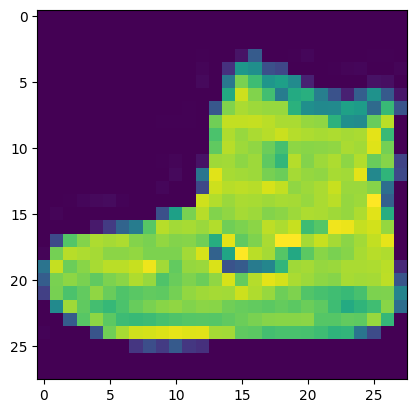

In [157]:
import matplotlib.pyplot as plt
import numpy as np

img, label = dataset_train[0]
plt.imshow(img[0])
print(f"Label:{label}")
img.shape

In [158]:
max= torch.max(img)
min = torch.min(img)
scale = max-min
print(scale)

from abstract import abstractTensor as AT

x=AT(img,alpha =0.001*scale*torch.ones(28*28))
x=x.abstract_tensor()
x.shape
x=x.to(device)
print(x.shape)


tensor(5.)
torch.Size([1, 28, 28])
torch.Size([786, 1, 28, 28])


In [159]:
with torch.no_grad():
   result_1= model(x[0].unsqueeze(0))  
 
   result,x_min,x_max,x_true=model.abstract_forward(x,add_symbol=True,device=torch.device('cpu'))

print(f"y_min       =  {x_min}")
print(f"y_max       =  {x_max}")
print(f"center Ztp  =  {result[0]}")
print(f"y_true      =  {x_true[:]}")
print(f"y_max-x_min =  {x_max-x_min}")
print(f"Trash symbol=  {result[-1]}")

torch.Size([1, 32, 24, 24])
torch.Size([1, 32, 12, 12])
x.shape=torch.Size([786, 1, 28, 28])
x.shape=torch.Size([827, 16, 26, 26])


/Users/guillaumeberthelot/anaconda3/envs/NumalisEnv/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


x.shape=torch.Size([1173, 32, 24, 24])
x.shape=torch.Size([1173, 32, 24, 24])
x.shape=torch.Size([1173, 32, 24, 24])
x.shape=torch.Size([1173, 32, 24, 24])
y_min       =  tensor([-0.0000, -0.0000, -0.0000, -0.0000,  2.1343, -0.0000, -0.0000,  6.9286,
         0.3297, 28.5660])
y_max       =  tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  4.4760,  0.0000,  0.0000,  8.1324,
         3.2948, 30.6449])
center Ztp  =  tensor([-0.0000, -0.0000, -0.0000, -0.0000,  3.3051, -0.0000, -0.0000,  7.5305,
         1.8122, 29.6054])
y_true      =  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  3.3419,  0.0000,  0.0000,  7.5643,
          1.6197, 29.6233]])
y_max-x_min =  tensor([0.0000, 0.0000, 0.0000, 0.0000, 2.3417, 0.0000, 0.0000, 1.2038, 2.9650,
        2.0788])
Trash symbol=  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [160]:
with torch.no_grad():
   result_1= model(x[0].unsqueeze(0))  
 
   result,x_min,x_max,x_true=model.abstract_forward(x,add_symbol=True,device=torch.device('cpu'))

print(f"y_min       =  {x_min}")
print(f"y_max       =  {x_max}")
print(f"center Ztp  =  {result[0]}")
print(f"y_true      =  {x_true[:]}")
print(f"y_max-x_min =  {x_max-x_min}")
print(f"Trash symbol=  {result[-1]}")


torch.Size([1, 32, 24, 24])
torch.Size([1, 32, 12, 12])
x.shape=torch.Size([786, 1, 28, 28])
x.shape=torch.Size([827, 16, 26, 26])
x.shape=torch.Size([1173, 32, 24, 24])
x.shape=torch.Size([1173, 32, 24, 24])
x.shape=torch.Size([1173, 32, 24, 24])
x.shape=torch.Size([1173, 32, 24, 24])
y_min       =  tensor([-0.0000, -0.0000, -0.0000, -0.0000,  2.1343, -0.0000, -0.0000,  6.9286,
         0.3297, 28.5660])
y_max       =  tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  4.4760,  0.0000,  0.0000,  8.1324,
         3.2948, 30.6449])
center Ztp  =  tensor([-0.0000, -0.0000, -0.0000, -0.0000,  3.3051, -0.0000, -0.0000,  7.5305,
         1.8122, 29.6054])
y_true      =  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  3.3419,  0.0000,  0.0000,  7.5643,
          1.6197, 29.6233]])
y_max-x_min =  tensor([0.0000, 0.0000, 0.0000, 0.0000, 2.3417, 0.0000, 0.0000, 1.2038, 2.9650,
        2.0788])
Trash symbol=  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Voici le premier affichage de relevance calculé par AbstractTorch

tensor(9)
torch.Size([784])


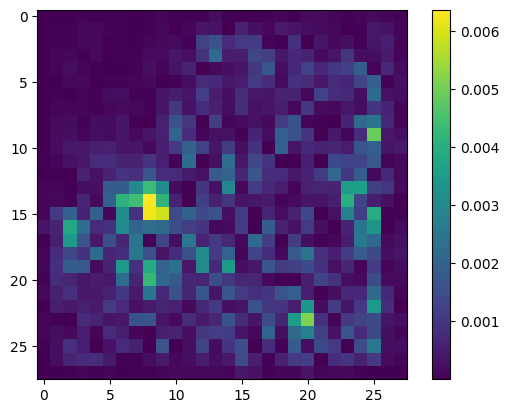

In [134]:
value=torch.argmax(result[0])
print(value)
concat= torch.abs(result[1:785,value])
print(concat.size())

concat = concat.reshape(28,28)
plt.imshow(torch.abs(concat.cpu()).numpy(), cmap='viridis')
plt.colorbar()

## Essai sur un réseau de grande dimension

In [2]:
from abstractModule import AbstractMaxpool2D as AM

In [136]:
class AbstractNN2(nn.Module):
    
    def __init__(self,num_depth=1,device=torch.device("cpu")):

        super(AbstractNN2,self).__init__()
       
      
        self.num_depth = num_depth
        self.device = device
        self.conv1=nn.Conv2d(self.num_depth,16,3,device=self.device)
        self.conv2=nn.Conv2d(16,16,3,device=self.device)
        self.conv3=nn.Conv2d(16,32,3,device=self.device) 
        self.conv4=nn.Conv2d(32,32,3,device=self.device)
        self.maxpool=nn.MaxPool2d(2,2)
        self.fc1=nn.Sequential(nn.Flatten(),nn.Linear(3200,6272,device=self.device))
        self.fc2=nn.Sequential(nn.Flatten(),nn.Linear(6272,6272,device=self.device))
        self.fc3=nn.Sequential(nn.Flatten(),nn.Linear(6272,6272,device=self.device))
        self.fc4=nn.Sequential(nn.Flatten(),nn.Linear(6272,6272,device=self.device))
        self.fc5=nn.Sequential(nn.Flatten(),nn.Linear(6272,512,device=self.device))
        self.fc6=nn.Sequential(nn.Flatten(),nn.Linear(512,256,device=self.device))
        self.fc7=nn.Sequential(nn.Flatten(),nn.Linear(256,8,device=self.device))

    
    def forward(self,x,add_symbol=False,device = torch.device("cpu")):

        self.device = device
        x_true = x
        x_true = x_true[0].unsqueeze(0)
        print(f"lenx:{len(x)}")
        x,x_min,x_max,x_true = AL.abstract_conv2D(self.conv1,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        print(f"lenx:{len(x)}")
       
        x,x_min,x_max,x_true = AL.abstract_conv2D(self.conv2,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        print(f"lenx:{len(x)}")
        x,x_min,x_max,x_true = AL.abstract_conv2D(self.conv3,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        print(f"lenx:{len(x)}")
        x,x_min,x_max,x_true = AL.abstract_conv2D(self.conv4,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        print(f"lenx:{len(x)}")

        x,x_min,x_max,x_true = AM.abstract_maxpool2D(self.maxpool,x,x_true,device=self.device)
        print(f"x.shape:{x.shape}")
        x,x_min,x_max,x_true = AL.abstract_linear(self.fc1,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        print(f"lenx:{len(x)}")
        x,x_min,x_max,x_true = AL.abstract_linear(self.fc2,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        print(f"lenx:{len(x)}")
        x,x_min,x_max,x_true = AL.abstract_linear(self.fc3,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        print(f"lenx:{len(x)}")
        x,x_min,x_max,x_true = AL.abstract_linear(self.fc4,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        print(f"lenx:{len(x)}")
        x,x_min,x_max,x_true = AL.abstract_linear(self.fc5,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        print(f"lenx:{len(x)}")
        x,x_min,x_max,x_true = AL.abstract_linear(self.fc6,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        print(f"lenx:{len(x)}")

        x,x_min,x_max,x_true = AL.abstract_linear(self.fc7,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        print(f"lenx:{len(x)}")
        return x,x_min,x_max,x_true

In [137]:
img = torch.randn(1,28,28)
from abstract import abstractTensor as AT

x=AT(img,alpha =0.001*torch.ones(28*28))
x=x.abstract_tensor()
x.shape
x=x.to(device)
print(x.shape)
model =AbstractNN2(num_depth=1,device=torch.device('cpu'))


model(x)

torch.Size([1, 28, 28])
torch.Size([786, 1, 28, 28])
lenx:786
x.shape=torch.Size([786, 1, 28, 28])
lenx:786
x.shape=torch.Size([786, 16, 26, 26])
lenx:786
x.shape=torch.Size([786, 16, 24, 24])
lenx:786
x.shape=torch.Size([786, 32, 22, 22])
lenx:786
kernel_size 2
x.shape=torch.Size([786, 32, 20, 20])
x.shape=torch.Size([786, 32, 20, 20])
x.shape=torch.Size([786, 32, 20, 20])
x.shape=torch.Size([786, 32, 20, 20])
x.shape:torch.Size([786, 32, 10, 10])
lenx:786
lenx:786
lenx:786
lenx:786
lenx:786
lenx:786
lenx:786


(tensor([[ 4263832.0000,  4645969.5000,  4711804.5000,  ...,
           4347658.5000,  4378832.0000,  4467462.5000],
         [       0.0000,        0.0000,        0.0000,  ...,
                 0.0000,        0.0000,        0.0000],
         [       0.0000,        0.0000,        0.0000,  ...,
                 0.0000,        0.0000,        0.0000],
         ...,
         [       0.0000,        0.0000,        0.0000,  ...,
                 0.0000,        0.0000,        0.0000],
         [       0.0000,        0.0000,        0.0000,  ...,
                 0.0000,        0.0000,        0.0000],
         [12739938.0000, 13520473.0000, 13952268.0000,  ...,
          13100498.0000, 12964662.0000, 13382398.0000]], grad_fn=<CopySlices>),
 tensor([-8476106., -8874504., -9240464., -8963618., -8954628., -8752840.,
         -8585830., -8914936.], grad_fn=<SubBackward0>),
 tensor([17003770., 18166442., 18664072., 18106772., 17509600., 17448156.,
         17343494., 17849860.], grad_fn=<AddBackward0